In [85]:
# Reference taken from http://syspedia.de/EgoNetworks/Ego-centric%20graphs.pdf

from operator import itemgetter

import matplotlib.pyplot as plt
import networkx as nx
import random
import config
from itertools import chain, combinations


def get_largest_hub(G):
    node_and_degree = G.degree()
    (largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]
    return largest_hub


def powerset_of_2(iterable):
    "powerset_of_2([(),(1),(1,2),(1,2,3)]) --> [(1,2)]"
    s = list(iterable)
    powerset = chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    powerset_of_2 = [s for s in powerset if len(s) == 2]
    return powerset_of_2


def get_unique_edges(edges):
    #  return list(set([(u, v) if u <= v else (v, u) for u, v in edges]))
    return list(set([(u, v) if u <= v else (v, u) for u, v in edges]))


def get_possible_edges(e0, e1, ego_net: nx.Graph, new_nodes: list[int]):
    '''
    These then have to be linked at random with each other and with those
    nodes in N(e0) that are neighbours of e1.
    '''

    possible_nodes = new_nodes
    possible_nodes.extend([n for n in nx.all_neighbors(
        ego_net, e0) if ego_net.has_edge(n, e1)])
    possible_edges = get_unique_edges(powerset_of_2(possible_nodes))

    return possible_edges


def set_new_edges(e0, e1, ego_net: nx.Graph, possible_edges, d, rho):
    '''
    The number of these edges is given by the
    required density of N(e1), i.e. d * (d - 1) * rho/2 - |E(N(e1))|

    where |E(N(e1))| is the number
    of edges between the neighbours of e1, which initially lie completely in N (e0).
    '''

    neighbors_of_e0 = list(nx.all_neighbors(ego_net, e0))
    neighbors_of_e1 = list(nx.all_neighbors(ego_net, e1))

    ENe1 = sum([list(ego_net.edges(n))
               for n in neighbors_of_e1], [])

    # Remove duplicate edges e.g. (2, 0) and (0,2) are the same
    ENe1 = get_unique_edges(ENe1)

    # Keep only those edges completely within neighbours of e0
    ENe1 = [(u, v)
            for u, v in ENe1 if (u in neighbors_of_e0) & (v in neighbors_of_e0)]

    num_set_edges = int(d * (d-1) * rho // 2 - len(ENe1))
    if num_set_edges < 0:
        num_set_edges = 0
    elif num_set_edges > len(possible_edges):
        num_set_edges = len(possible_edges)

    for u, v in random.sample(possible_edges, num_set_edges):
        ego_net.add_edge(u, v)


def sample_new_ego(ego_net, d):
    '''
    Get a random ego node that has not yet reached the defined degree of "d"
    '''
    # The nodes that have not reached the defined degree yet
    incomplete_nodes = [n for n in ego_net.nodes() if ego_net.degree[n] < d]
    # The ego node of the current iteration
    e1 = random.choice(incomplete_nodes)
    return e1


def create_new_nodes(ego_net, num_missing_nodes, e1):
    new_nodes = []

    for _ in range(num_missing_nodes):
        new_node = ego_net.number_of_nodes()
        ego_net.add_node(new_node)
        ego_net.add_edge(new_node, e1)
        new_nodes.extend([new_node])

    return new_nodes


61


0.7601817179927113

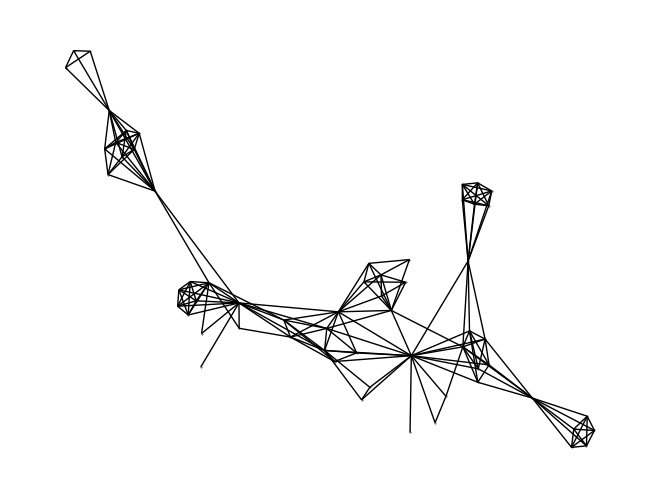

In [135]:

'''
The general procedure is to start with a random ego-network N (e0 ) with d and ρ taken
from the probability distributions (the “seed network”). 
'''
d = 10
rho = 0.51
p = config.edge_creation_probability
seed = 20532


G = nx.erdos_renyi_graph(d, p, seed=seed, directed=False)
# find node with largest degree
e0 = get_largest_hub(G)

ego_net: nx.Graph = nx.ego_graph(G, e0, undirected=True)

'''
with all nodes additionally
linked to e0.
'''
for n in ego_net.nodes():
    if n != e0:
        ego_net.add_edge(n, e0)

mapping = {old: new for old, new in zip(
    ego_net.nodes(), range(ego_net.number_of_nodes()))}
ego_net = nx.relabel_nodes(ego_net, mapping)

'''
The next ego-network N (e1) is created by picking an e1 ∈ N (e0) at
random, checking the number of missing edges d − d(e1) and adding as many new nodes
from scratch. These then have to be linked at random with each other and with those
nodes in N (e0 ) that are neighbours of e1 .
'''


increase_steps = 1
decrease_steps = 1


step = 0
while step < increase_steps:

    e1 = sample_new_ego(ego_net, d)

    num_missing_nodes = d - ego_net.degree[e1]

    new_nodes = create_new_nodes(ego_net, num_missing_nodes, e1)

    possible_edges = get_possible_edges(e0, e1, ego_net, new_nodes)
    set_new_edges(e0, e1, ego_net, possible_edges, d, rho)

    e0 = e1
    step += 1


# Seed layout for reproducibility
pos = nx.spring_layout(ego_net, seed=seed)

# Draw graph
nx.draw(ego_net, pos, node_color="black", node_size=0.1, with_labels=False)
print(ego_net.number_of_nodes())
nx.average_clustering(ego_net)


[0, 1, 2, 3, 6, 7, 9, 10, 11, 12, 13, 20, 21, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]
98


0.4457042990356317

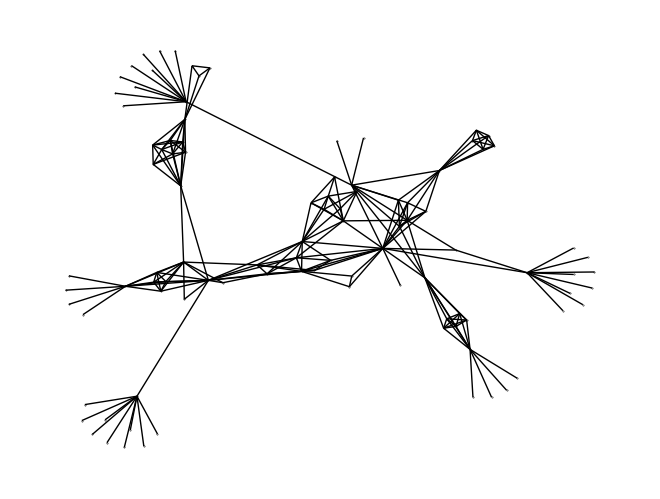

In [141]:
step = 0
while step < decrease_steps:
    e1 = sample_new_ego(ego_net, d)

    num_missing_nodes = d - ego_net.degree[e1]

    '''
    During the decrease stage, we reduce the amount of new nodes, 
    while taking the rest from the exisiting nodes, conforming to 2 restrictions
    '''
    num_new_nodes = round((1 - step/decrease_steps) * num_missing_nodes)

    num_sample_nodes = num_missing_nodes - num_new_nodes

    # The nodes newly created combined with the existing nodes qualified
    new_nodes = create_new_nodes(ego_net, num_new_nodes, e1)

    '''
    ...But only those are allowed which fulfill the requirements: (i) the degree d(ei)
    must be smaller than d, and (ii) they must not be in one of the ego-networks that the
    current ego-node ej is already in
    
    How do we find out that the existing node is not inside any of the network of the
    current ego node?
    
    1. find all the networks that e1 is in:
        follow up: How do we know that? 
    2. excluding that from the exisiting nodes list
    
    I mean the definition of an ego network is the central node and its direct neighbors right?
    So we just have to filter out all the ego networks formed by e1's direct neighbors, since any
    thing beyond that is not going to form a large enough ego network that would overlap e1   
    '''

    unqualified_nodes = list(set(sum([list(nx.all_neighbors(
        ego_net, neighbor)) for neighbor in nx.all_neighbors(ego_net, e1)], [])))

    qualified_nodes = [n for n in ego_net.nodes()
                       (n not in unqualified_nodes)]

    
    # print(ego_net.nodes())
    print(unqualified_nodes)    
    print(qualified_nodes)
    # sampleNodesFrom(qualified_nodes, num_sample_nodes)

    # new_nodes.extend(qualified_nodes)
    # possibleEdges = getPossibleEdges(ego, newNodes)
    # setNewEdges(ego, possibleEdges, rho)

    e0 = e1
    step += 1


# Seed layout for reproducibility
pos = nx.spring_layout(ego_net, seed=seed)

# Draw graph
nx.draw(ego_net, pos, node_color="black", node_size=0.1, with_labels=False)
print(ego_net.number_of_nodes())
nx.average_clustering(ego_net)


In [4]:
temp_set = list(set([(1,2), (1,2)]))
print(temp_set)

[(1, 2)]
